In [1]:
import sys

import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")

physical_device = tf.config.experimental.list_physical_devices('GPU')
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
GPU is available


In [2]:
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import pathlib

## Download the data
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file(origin=dataset_url,fname='flower_photos',untar=True)


## create train and validation datasets
DB_PATH = "G://Datasets//fashiondb//images"
BUFFER_SIZE = 10000
BATCH_SIZE = 1000
IMG_WIDTH = 60
IMG_HEIGHT = 60

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=3)

    input_image = tf.cast(image, tf.float32)
    return input_image

def random_crop(input_image):
    cropped_image = tf.image.random_crop(
      input_image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

def resize(input_image):
    input_image = tf.image.resize(input_image, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image

def normalize(input_image):
    input_image = (input_image / 255)
    return input_image

@tf.function()
def random_jitter(input_image):
    input_image = random_crop(input_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        
    return input_image

def load_image_train(image_file):
    input_image = load(image_file)
    #input_image = random_jitter(input_image)
    input_image = resize(input_image)
    input_image = normalize(input_image)

    return input_image,input_image

def load_image_test(image_file):
    input_image = load(image_file)
    #input_image = random_jitter(input_image)
    input_image = resize(input_image)
    input_image = normalize(input_image)

    return input_image,input_image


data_dir = pathlib.Path(DB_PATH)
image_count = len(list(data_dir.glob('*.jpg')))
dataset = tf.data.Dataset.list_files(DB_PATH+'\\*.jpg')


val_size = int(image_count * 0.2)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


train_ds = train_ds.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_ds = val_ds.map(load_image_test)
val_ds = val_ds.batch(BATCH_SIZE)




#from tensorflow.python.framework.ops import disable_eager_execution 
#disable_eager_execution()

35553
8888


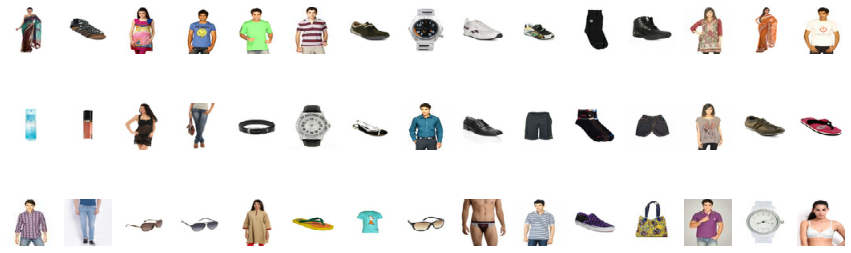

In [54]:
#image_batch = next(iter(train_ds))

plt.figure(figsize=(15, 5))
for images,targets in val_ds.take(1):
    for i in range(45):
      ax = plt.subplot(3, 15, i + 1)
      plt.imshow(images[i].numpy().astype("float32"))
      plt.axis("off")

In [39]:
# Embedding Images to PCA Space
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(32)
imgs_list = []
vis_imgs = []
for images,targets in val_ds.take(1):
    for i in range(BATCH_SIZE):
        vis_imgs.append(tf.keras.preprocessing.image.img_to_array(images[i]))
        image = tf.image.rgb_to_grayscale(images[i])
        img_arr = tf.keras.preprocessing.image.img_to_array(image)
        imgs_list.append(img_arr.ravel())
img_mat = np.array(imgs_list)
print("Image Mat Shape:")
print(img_mat.shape)
pca_feat = pca.fit_transform(img_mat)
print("No. of PCA Features:")
print(pca_feat.shape)

Image Mat Shape:
(1000, 3600)
No. of PCA Features:
(1000, 32)


D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.493542
[t-SNE] Computed conditional probabilities in 0.045s
[t-SNE] Iteration 50: error = 66.2570419, gradient norm = 0.2094555 (50 iterations in 0.271s)
[t-SNE] Iteration 100: error = 63.6357155, gradient norm = 0.1276759 (50 iterations in 0.204s)
[t-SNE] Iteration 150: error = 63.2299461, gradient norm = 0.1139620 (50 iterations in 0.203s)
[t-SNE] Iteration 200: error = 63.1434441, gradient norm = 0.1084849 (50 iterations in 0.205s)
[t-SNE] Iteration 250: error = 63.1553917, gradient norm = 0.1172022 (50 iterations in 0.222s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.155392
[t-SNE] Iteration 300: error = 0.8214933, gradient norm = 0.0008211 (50 iterations in 0.212s)
[t-SNE] Iteration 350: error = 0.7311287, gradient norm = 0.00027

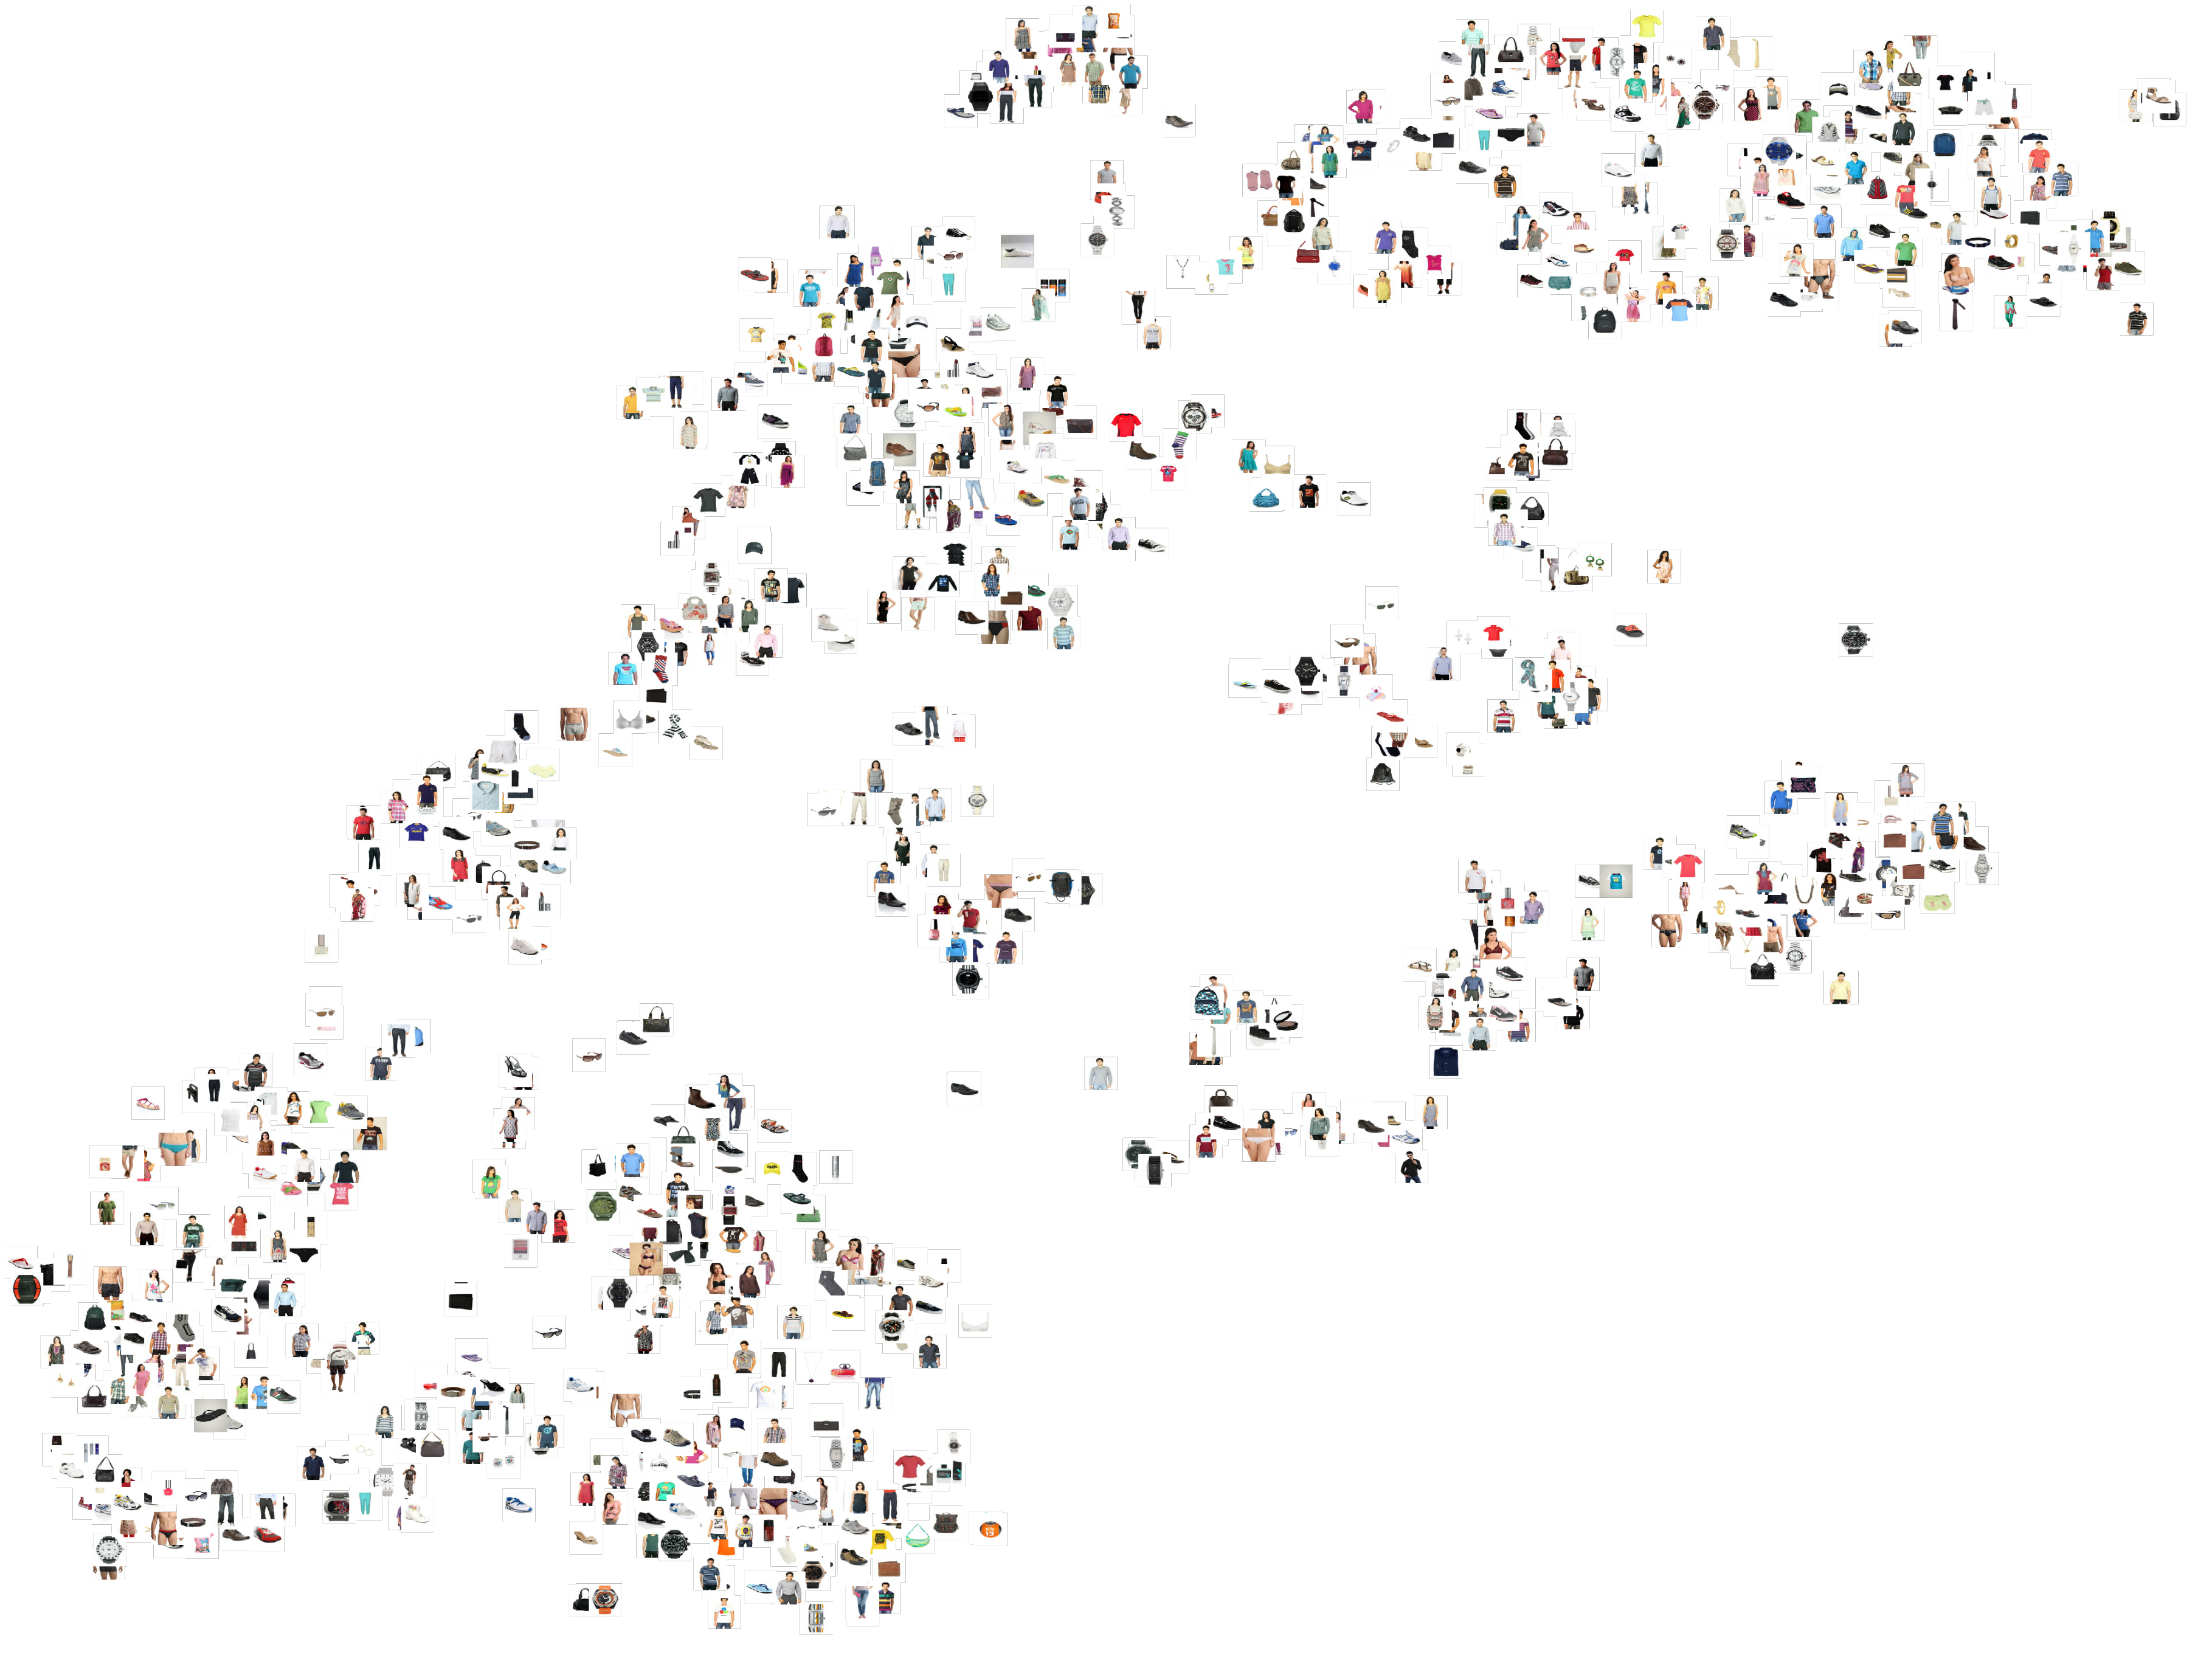

In [74]:
from PIL import Image
from sklearn.manifold import TSNE

def visualize_space(X,images,outfile):

    tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)
    tx, ty = tsne[:,0], tsne[:,1]
    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
    width = 4000
    height = 3000


    full_image = Image.new('RGBA', (width, height))
    for img, x, y in zip(images, tx, ty):
        img = np.array(img)
        tile = Image.fromarray(np.uint8(img*255))
        full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

    plt.figure(figsize = (66,50))
    plt.imshow(full_image)
    plt.axis("off")
    full_image.save(outfile)

X = np.array(pca_feat)
visualize_space(X,vis_imgs,"tSNE-PCA-fashiondb.png")

In [62]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K

batch_size = 16
latent_dim = 32  # Number of latent dimension parameters

input_img = Input(shape=(60, 60, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)

Z = Dense(latent_dim)(x)
print(K.int_shape(Z))

encoder = Model(input_img,Z)
encoder.summary()

(None, 8, 8, 1)
(None, 32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 60, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 60, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 4)         580       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None

In [63]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(Z)[1:])
x = Dense(15*15*4, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)
# Expand to 900 total pixels
x = Dense(900, activation='sigmoid', name="original_decoder")(x)
x = Reshape((15,15,4),input_shape=(900,))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)


# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(Z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
intermediate_decoder (Dense) (None, 900)               29700     
_________________________________________________________________
original_decoder (Dense)     (None, 900)               810900    
_________________________________________________________________
reshape (Reshape)            (None, 15, 15, 4)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 15, 15, 3)         111       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 30, 30, 3)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 30, 30, 3)         84  

In [64]:
# VAE model statement
ae = Model(input_img,z_decoded)
ae.compile(optimizer='adam', loss='mse')

ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 60, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 60, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 4)         580       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 4)           0   

In [76]:
from keras.callbacks import EarlyStopping
# run the model
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = ae.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stopping],verbose=1)

Epoch 1/10
36/36 [==============================] - 22s 509ms/step - loss: 0.0403 - val_loss: 0.0381
Epoch 2/10
36/36 [==============================] - 21s 501ms/step - loss: 0.0366 - val_loss: 0.0354
Epoch 3/10
36/36 [==============================] - 20s 479ms/step - loss: 0.0340 - val_loss: 0.0326
Epoch 4/10
36/36 [==============================] - 21s 495ms/step - loss: 0.0317 - val_loss: 0.0315
Epoch 5/10
36/36 [==============================] - 21s 502ms/step - loss: 0.0301 - val_loss: 0.0292
Epoch 6/10
36/36 [==============================] - 21s 491ms/step - loss: 0.0286 - val_loss: 0.0278
Epoch 7/10
36/36 [==============================] - 20s 482ms/step - loss: 0.0273 - val_loss: 0.0268
Epoch 8/10
36/36 [==============================] - 20s 480ms/step - loss: 0.0263 - val_loss: 0.0262
Epoch 9/10
36/36 [==============================] - 20s 480ms/step - loss: 0.0255 - val_loss: 0.0251
Epoch 10/10
36/36 [==============================] - 21s 488ms/step - loss: 0.0246 - val_lo

In [77]:
# Project validation set into Latent Space
vis_imgs = []
for input_images,output_images in val_ds.take(1):
    latent_vec = encoder(input_images)
    for i in range(BATCH_SIZE):
        vis_imgs.append(tf.keras.preprocessing.image.img_to_array(input_images[i]))
print("Dimension of Latent Space:")
print(latent_vec.shape)

Dimension of Latent Space:
(1000, 32)


D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.369303
[t-SNE] Computed conditional probabilities in 0.042s
[t-SNE] Iteration 50: error = 65.1580353, gradient norm = 0.1838877 (50 iterations in 0.282s)
[t-SNE] Iteration 100: error = 61.4252281, gradient norm = 0.0827636 (50 iterations in 0.227s)
[t-SNE] Iteration 150: error = 61.2716522, gradient norm = 0.0550817 (50 iterations in 0.217s)
[t-SNE] Iteration 200: error = 61.2633133, gradient norm = 0.0683629 (50 iterations in 0.222s)
[t-SNE] Iteration 250: error = 61.2665443, gradient norm = 0.0723807 (50 iterations in 0.222s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.266544
[t-SNE] Iteration 300: error = 0.7856371, gradient norm = 0.0006774 (50 iterations in 0.205s)
[t-SNE] Iteration 350: error = 0.7076021, gradient norm = 0.00021

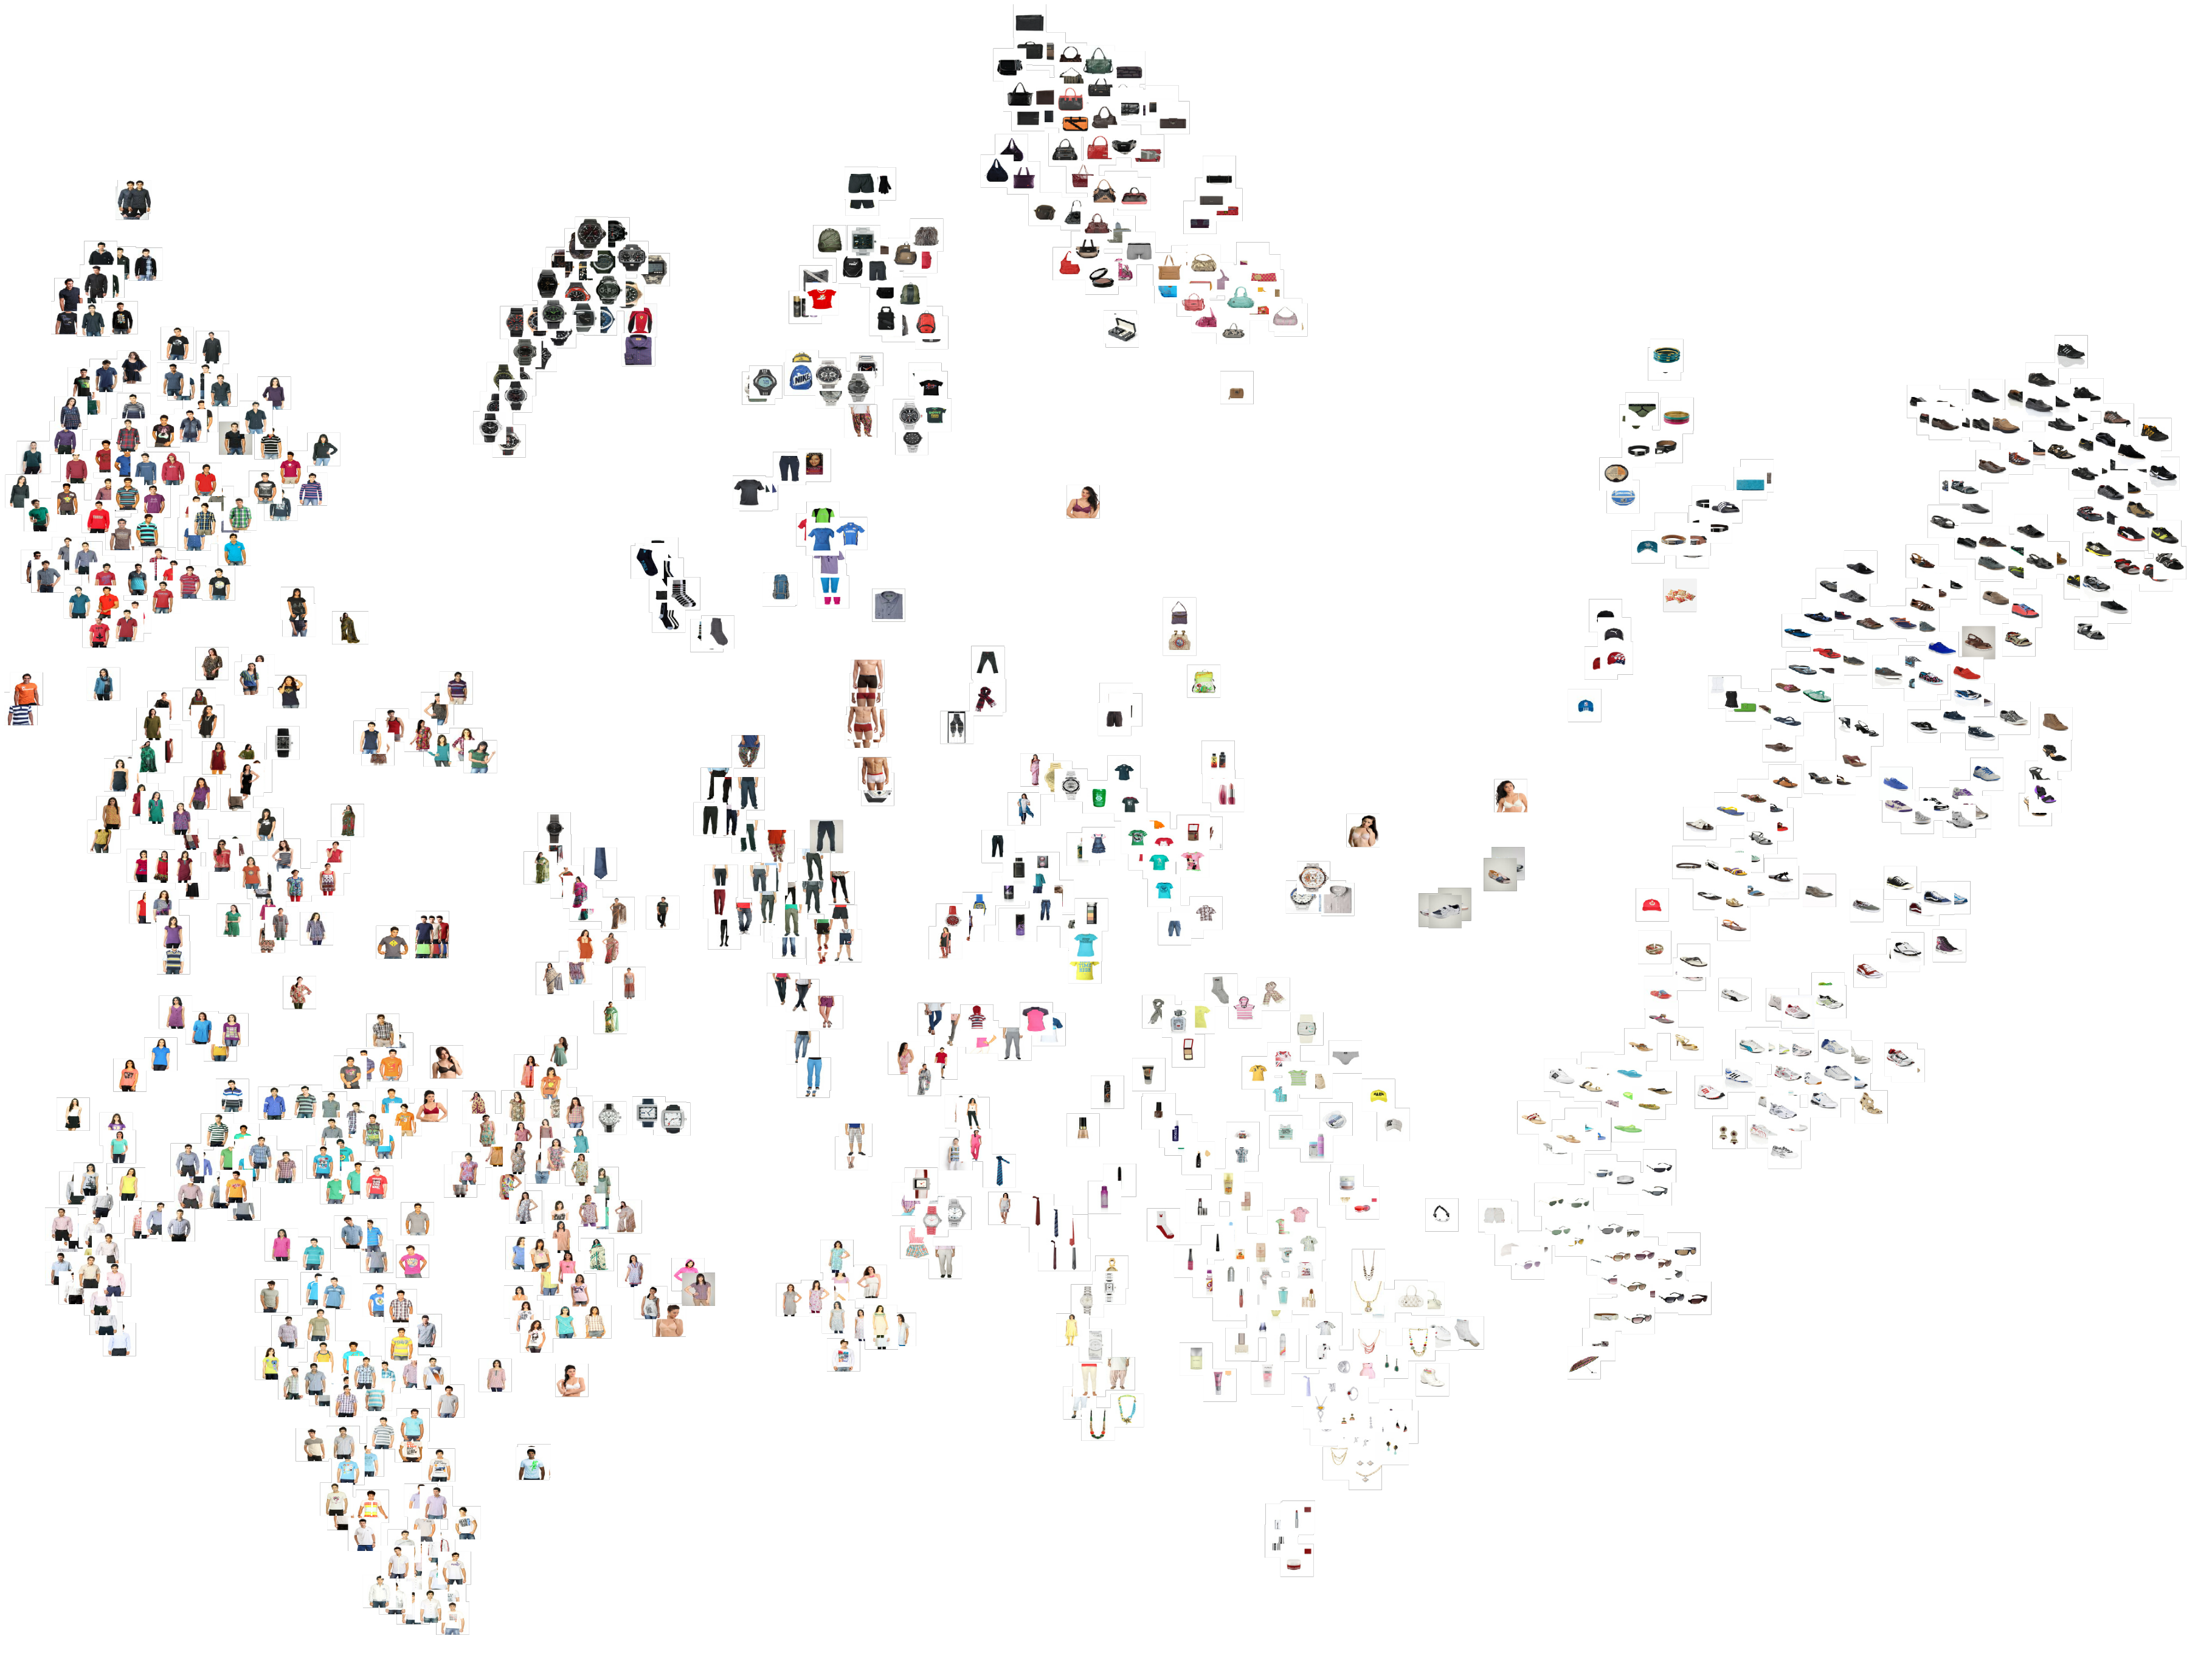

In [79]:
X= np.array(latent_vec)

visualize_space(X,vis_imgs,"tSNE-Latent-fashiondb.png")

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 28, 28, 64)   640         input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 14, 14, 64)   0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 14, 14, 32)   18464       max_pooling2d_20[0][0]           
___________________________________________________________________________________________

(48000, 28, 28, 1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 14s 285us/sample - loss: 0.4217 - val_loss: 0.3901
Epoch 2/20
48000/48000 [==============================] - 12s 259us/sample - loss: 0.3852 - val_loss: 0.3816
Epoch 3/20
48000/48000 [==============================] - 12s 256us/sample - loss: 0.3771 - val_loss: 0.3720
Epoch 4/20
48000/48000 [==============================] - 12s 255us/sample - loss: 0.3571 - val_loss: 0.3442
Epoch 5/20
48000/48000 [==============================] - 12s 251us/sample - loss: 0.3429 - val_loss: 0.3431
Epoch 6/20
48000/48000 [==============================] - 12s 245us/sample - loss: 0.3400 - val_loss: 0.3392
Epoch 7/20
48000/48000 [==============================] - 12s 250us/sample - loss: 0.3384 - val_loss: 0.3400
Epoch 8/20
48000/48000 [==============================] - 12s 254us/sample - loss: 0.3373 - val_loss: 0.3376
Epoch 9/20
48000/48000 [==============================] - 12s 259us/sample - l